Analysis of the Community Structure of the Network
===

In this notebook, we will analyze the community structure of the network of bitcoin transactions. We experiement different method to detect communities in the network, for example, the Louvain method ([Louvain method](https://en.wikipedia.org/wiki/Louvain_method)) and the Girvan-Newman method ([Girvan-Newman method](https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm)). We will also analyze the properties of the communities, such as the size of the communities, the number of transactions in the communities, ect..

---

In [1]:
# %pip install python-louvain
# %pip install infomap
# %pip install plotly
# %pip install nbformat>=4.2.0

In [2]:
# for auto-reload
%load_ext autoreload
%aimport utils.utils
%aimport utils.actor
%aimport utils.transaction
%aimport utils.community
%aimport utils.graph
%aimport utils.network
%autoreload 1

## Import Required Libraries
We will start by importing the libraries we need for this project. You can install any missing libraries by running the code cell above.

In [3]:
from tabulate import tabulate
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr
import community as community_louvain
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

from utils.utils import load_all_csv_in_dir
from utils.community import Community
from utils.network import Network
from utils.actor import Actor

## Load Data

First of all, the network data is stored in csv files. Each file name is the date of the transactions. We will load all the csv files and combine them into one dataframe.
The data is stored in the following format:
- `Source`: The source of the transaction
- `Target`: The target of the transaction
- `Value`: The amount transferred in the transaction
- `Date`: The date of the transaction

In [4]:
data_dir = "../data/networks/"

transaction_features_df = load_all_csv_in_dir(data_dir)
transaction_features_df = transaction_features_df.sort_values(by="date").reset_index(drop=True)

print(transaction_features_df.shape)
transaction_features_df.head()

(5876734, 5)


,Source,Target,value,nb_transactions,date
0,73937548,69565876,70039010,1,2015-01-01
1,ePay.info_CoinJoinMess,Betcoin.ag,31190000,6,2015-01-01
2,BTC-e.com,Cryptsy.com,4397385506,6,2015-01-01
3,ePay.info_CoinJoinMess,Bleutrade.com,18176239,1,2015-01-01
4,Cryptsy.com,Loanbase.com,24888230,1,2015-01-01


In [5]:
# TODO : remove this cell
# transaction_features_df = transaction_features_df.head(1000000)
# transaction_features_df.shape

## Data Preparation

Before starting the analysis, we will prepare the data for the analysis. To simplify the manipulation of the data, we created different classes to represent the data. The classes are:
- `Transaction`: This class represents a transaction in the network. It contains the source, the target, the value and the date of the transaction.
- `Actor`: This class represents an actor in the network. It contains the list of transactions in which the actor is involved.
- `Network`: This class represents the whole network. It contains the graph of the network and enables to perform operations on the network (such as adding a transaction, adding an actor, etc..).

Since the data is stored inside the `transactions_features_df` dataframe, we will extract the data and create the different classes.

In [6]:
actors_names = sorted(list(set(transaction_features_df["Source"].unique()).union(set(transaction_features_df["Target"].unique()))), reverse=True)
actors = [Actor(name, -1) for name in actors_names]
actor_dict = {actor.name: actor for actor in actors}

In [7]:
def process_row(row):
    source = row["Source"]
    target = row["Target"]
    weight = row["value"]
    nb_transactions = row["nb_transactions"]

    source_actor = actor_dict[source]
    target_actor = actor_dict[target]

    source_actor.process_transaction(target_actor, weight, nb_transactions, row["date"])

We process the transaction for each actor and add the transaction to the actor's list of transactions. 

In [8]:
transaction_features_df.apply(process_row, axis=1)
print("done")

done


we also compute the volume of transactions for each actor by day. We will use this information later to compute the volume of transactions by day for each community.

In [9]:
for actor in actors:
    actor.process_volume_by_day()

### Create the Network

Now that we have the data in the right format, we can create the network. We will create a network object and add the actors to the network. Each actor will be represented by a node in the network, and the edges will represent the transactions between the actors.

In [10]:
network = Network(actors)
network.construct_network()

# Community Detection

Our goal is to detect the communities in the network. Our `Network` class implement the Louvain method and the Girvan-Newman method to detect the communities in the network. We will use both methods to detect the communities in the network and compare the results.

In [11]:
# network.process_communities_networkx()
network.process_communities_louvain()
network.print_communities()

  Id  Members
----  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

For each community, we will compute the following metrics:
- The size of the community
- The volume sent by the community
- The volume received by the community
- The number of transactions done by the community
- The number of unique transactions done by the community

In [12]:
communities = []
for actor_names in network.communities:
    sended = sum([actor_dict[actor].get_volume_sended() for actor in actor_names])
    received = sum([actor_dict[actor].get_volume_received() for actor in actor_names])
    
    nb_transactions = sum([actor_dict[actor].get_nb_transactions() for actor in actor_names])
    nb_unique_transactions = sum([actor_dict[actor].get_nb_unique_transactions() for actor in actor_names])
    transactions = [transaction for actor in actor_names for transaction in actor_dict[actor].get_transactions()]

    community = Community(sorted(actor_names), sended, received, nb_transactions, nb_unique_transactions, transactions)
    community.process_volume_by_day()
    communities.append(community)
    
    # we update the actor community id for each actor
    for actor_name in actor_names:
        actor_dict[actor_name].set_community(community)

In [13]:
actors[0].print()

Name                    Community          Total Volume         Sent Volume    Received Volume    Total Transactions    Unique Transactions
----------------------  -----------  ------------------  ------------------  -----------------  --------------------  ---------------------
ePay.info_CoinJoinMess  Community 1  182440547321029853  181393317415721002   1047229905308851               5479982                 113595


We also implemented methods inside the subclasse `Graph` to analyze a graph. We will use these methods to analyze the communities.

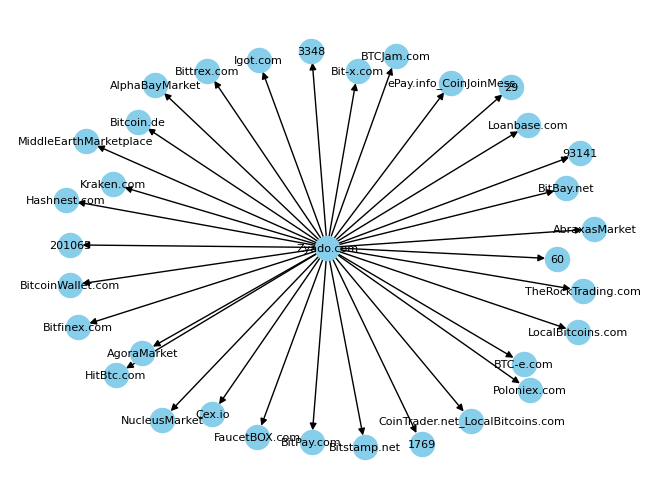

In [14]:
network.get_edges_subgraph("Zyado.com", out_edges=True).plot_graph()

In [15]:
print("Number of communities: ", len(communities))
communities.sort(key=lambda x: x.get_volume(), reverse=True)
tab = [[community.get_name(), community.get_volume(), community.get_nb_transactions(), community.get_nb_unique_transactions(), len(community.members), community.get_nb_transactions() / len(community.members), community.get_nb_unique_transactions() / len(community.members)] for community in communities]
print(tabulate(tab, headers=["Id", "Volume", "Nb transactions", "Nb unique transactions", "Nb actors", "Nb transactions / Nb actors", "Nb unique transactions / Nb actors"]))

# Compute the average of each metric
metrics = np.array(tab)[:, 1:].astype(float)
avg_metrics = np.mean(metrics, axis=0)

print()
print(tabulate([avg_metrics], headers=["Volume", "Nb transactions", "Nb unique transactions", "Nb actors", "Nb transactions / Nb actors", "Nb unique transactions / Nb actors"]))

Number of communities:  7
Id                       Volume    Nb transactions    Nb unique transactions    Nb actors    Nb transactions / Nb actors    Nb unique transactions / Nb actors
-----------  ------------------  -----------------  ------------------------  -----------  -----------------------------  ------------------------------------
Community 2  252642036992795583           24499994                   3393248         3142                       7797.58                               1079.96
Community 1  227188188470765066           10317848                   1635293         5479                       1883.16                                298.466
Community 7  102440877876442256            2036082                    334012          652                       3122.83                                512.288
Community 4     580359604812655             576499                    492022          546                       1055.86                                901.139
Community 3      2601

# Overview of the Network

Now that we have the communities, and actors, we can analyze the data. We will start by plotting some graphs to visualize the data. To have a rough idea of the data distribution.


In [16]:
def overview_of_top_communities(communities, top=10):
    sns.set(style="whitegrid")

    top_10_communities = sorted(communities, key=lambda x: x.get_volume(), reverse=True)[:top]
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    top_10_community_names = list(map(lambda community: community.get_name(), top_10_communities))
    
    # Plot total volume per community
    sns.barplot(x=list(map(lambda community: community.get_volume(), top_10_communities)), y=top_10_community_names, color='skyblue', ax=axes[0, 0])
    axes[0, 0].set_title(f'Top {top} Communities - Total Volume Exchanged')

    # Plot total volume received per community
    sns.barplot(x=list(map(lambda community: community.get_received(), top_10_communities)), y=top_10_community_names, color='salmon', ax=axes[0, 1])
    axes[0, 1].set_title(f'Top {top} Communities - Total Volume Received')

    # Plot total volume sent per community
    sns.barplot(x=list(map(lambda community: community.get_sended(), top_10_communities)), y=top_10_community_names, color='lightgreen', ax=axes[1, 0])
    axes[1, 0].set_title(f'Top {top} Communities - Total Volume Sent')

    # Plot number of transactions per community with unique transactions in lower opacity
    sns.barplot(x=list(map(lambda community: community.get_nb_transactions(), top_10_communities)), y=top_10_community_names, color='gold', ax=axes[1, 1], label='Number of Transactions')
    sns.barplot(x=list(map(lambda community: community.get_nb_unique_transactions(), top_10_communities)), y=top_10_community_names, color='red', alpha=0.5, ax=axes[1, 1], label='Number of Unique Transactions')
    axes[1, 1].set_title(f'Top {top} Communities - Number of Transactions')

    # Plot the size of the communities
    sns.barplot(x=list(map(lambda community: community.get_size(), top_10_communities)), y=top_10_community_names, color='orange', ax=axes[0, 2])
    axes[0, 2].set_title(f'Top {top} Communities - Size')

    # Plot the evolution over time of the total volume exchanged for each community
    for community in top_10_communities:
        volume_by_day = community.get_transactions_volume_by_day()
        sns.lineplot(x=[t.date for t in volume_by_day], y=[t.value for t in volume_by_day], label=community.get_name(), ax=axes[1, 2])
        
    axes[1, 2].set_title(f'Evolution Over Time - Total Volume Exchanged for Each Community')
    axes[1, 2].legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

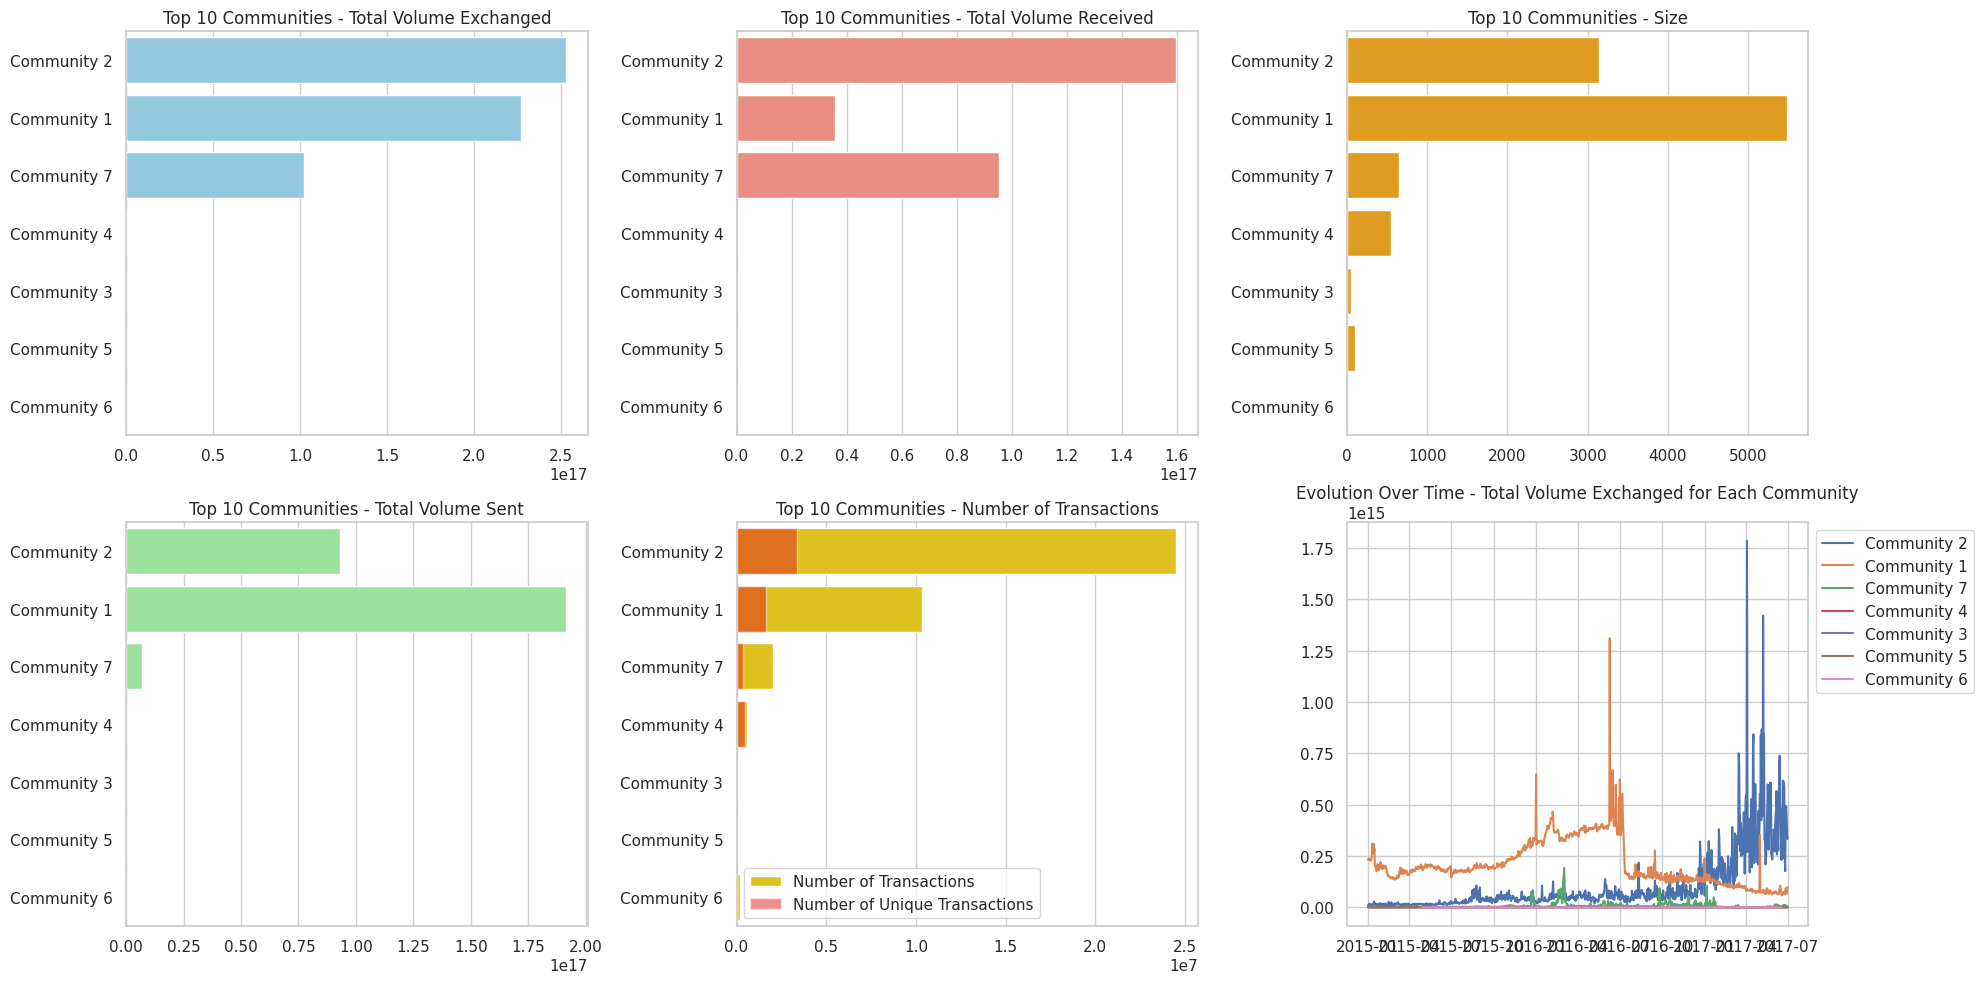

In [17]:
overview_of_top_communities(communities, top=10)

In [18]:
def evolution_of_communities_exchange(communities, top=10):
    sns.set(style="whitegrid")

    top_10_communities = sorted(communities, key=lambda x: x.get_volume(), reverse=True)[:top]
    fig, axes = plt.subplots(3, 1, figsize=(20, 10))

    for community in top_10_communities:
        volume_by_day = community.get_transactions_volume_by_day()
        x = [t.date for t in volume_by_day]
        y = [t.value for t in volume_by_day]
        sns.lineplot(x=x, y=y, label=community.get_name(), ax=axes[0])
        
    axes[0].set_title(f'Evolution Over Time - Total Volume Exchanged for Each Community')
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

    for community in top_10_communities[:4]:
        volume_by_day = community.get_transactions_volume_by_day()
        x = [t.date for t in volume_by_day]
        y = (np.array([t.value for t in volume_by_day]) - np.min([t.value for t in volume_by_day])) / (np.max([t.value for t in volume_by_day]) - np.min([t.value for t in volume_by_day]))
        sns.lineplot(x=x[:len(y)], y=y, label=community.get_name(), ax=axes[1])

    axes[1].set_title(f'Normalized Evolution Over Time - Total Volume Exchanged for Each Community')
    axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # compute the moving average of the normalized values for each community
    for community in top_10_communities:
        volume_by_day = community.get_transactions_volume_by_day()
        x = [t.date for t in volume_by_day]
        y = (np.array([t.value for t in volume_by_day]) - np.min([t.value for t in volume_by_day])) / (np.max([t.value for t in volume_by_day]) - np.min([t.value for t in volume_by_day]))
        moving_average = np.convolve(y, np.ones(7), 'valid') / 7
        sns.lineplot(x=x[:len(moving_average)], y=moving_average, label=community.get_name(), ax=axes[2])
    
    axes[2].set_title(f'Moving Average of Normalized Evolution Over Time - Total Volume Exchanged for Each Community')
    axes[2].legend(loc='upper left', bbox_to_anchor=(1, 1))  

    plt.tight_layout()
    plt.show()

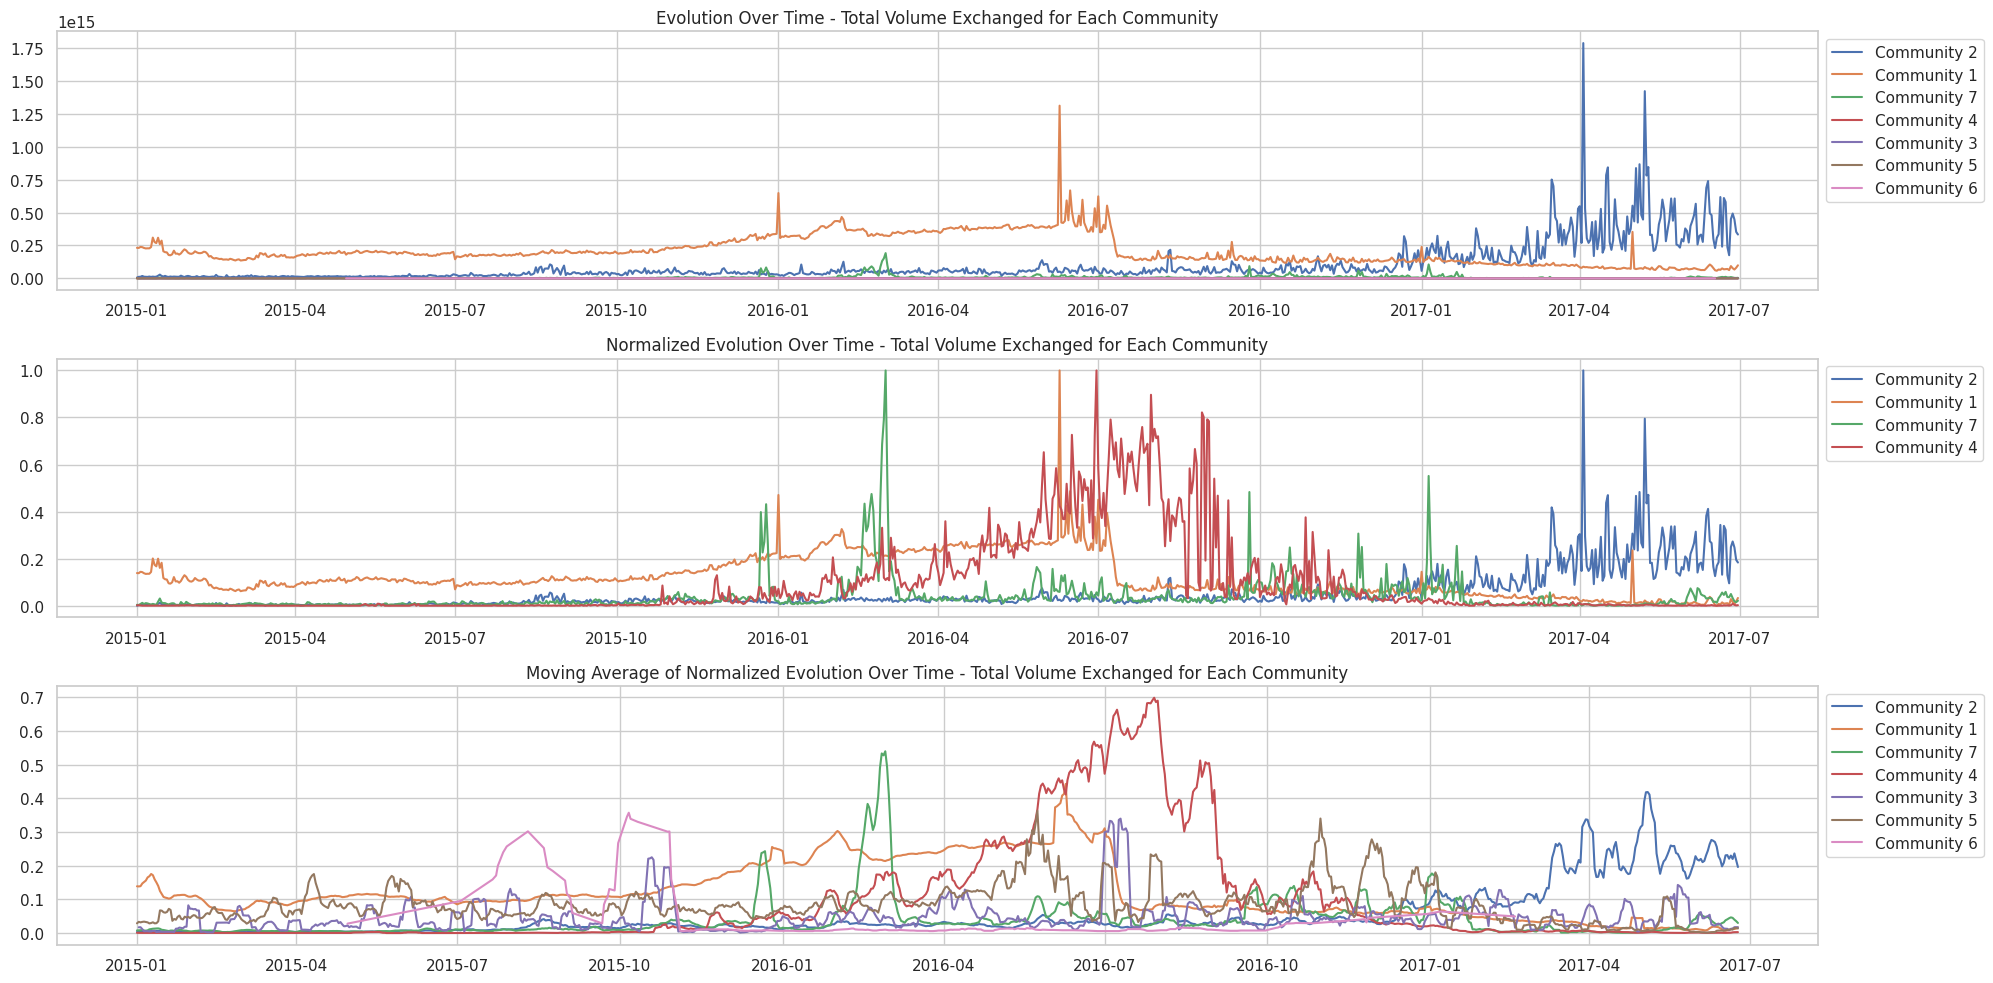

In [19]:
evolution_of_communities_exchange(communities)

In [24]:
def correlation_between_communities(communities, top=10):
    plt.figure(figsize=(20, 10))
    sns.set(style="whitegrid")

    top_10_communities = sorted(communities, key=lambda x: x.get_volume(), reverse=True)[:top]

    # Create a DataFrame to store the normalized values and moving averages
    df = pd.DataFrame()

    for community in top_10_communities:
        volume_by_day = community.get_transactions_volume_by_day()
        y = (np.array([t.value for t in volume_by_day]) - np.min([t.value for t in volume_by_day])) / (np.max([t.value for t in volume_by_day]) - np.min([t.value for t in volume_by_day]))
        moving_average = np.convolve(y, np.ones(7), 'valid') / 7

        # Store data in the DataFrame
        df[community.get_name()] = pd.Series(moving_average)

    # Compute the correlation matrix
    corr = df.corr()

    # Plot heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)

    # Beautify the labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.title(f'Correlation Between Moving Averages of Normalized Volume for Top {top} Communities')
    plt.show()


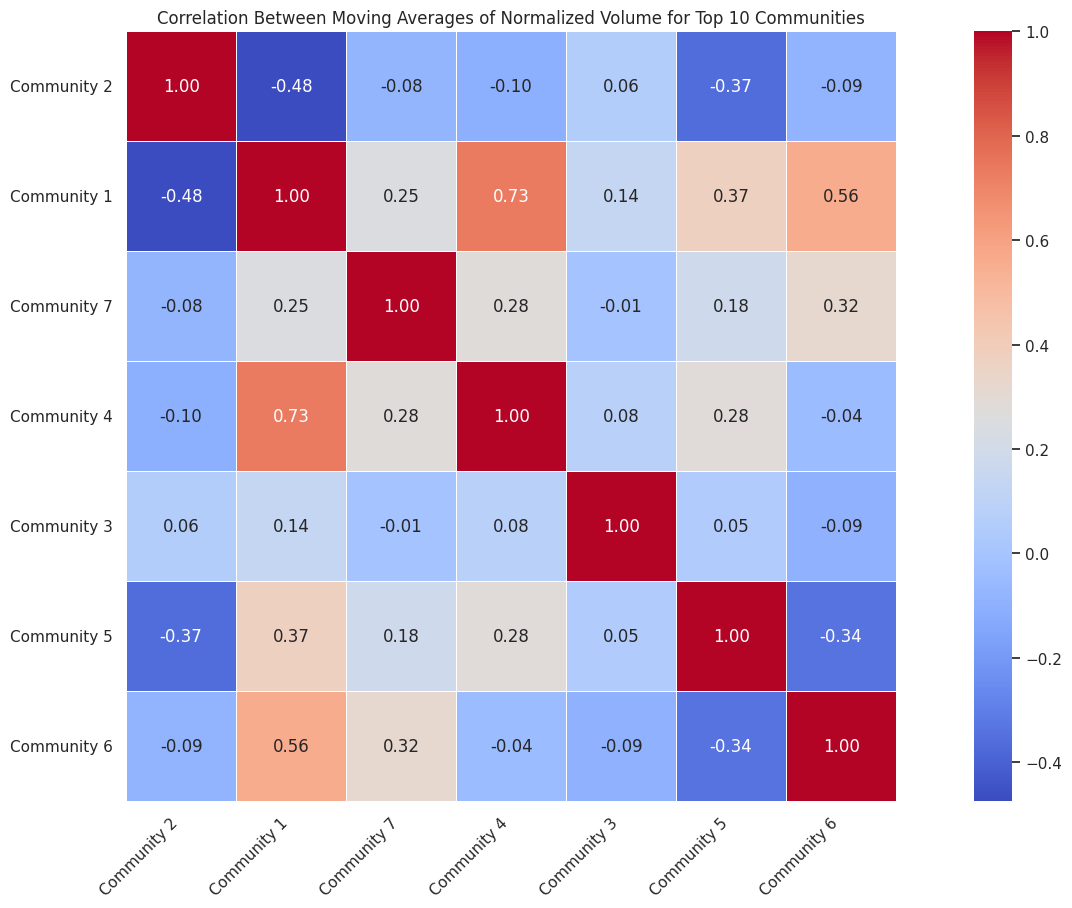

In [25]:
correlation_between_communities(communities)

In [18]:
def overview_of_top_actors(actors, top=10):
    sns.set(style="whitegrid")
    
    top_10_actors = sorted(actors, key=lambda a: a.get_total_volume(), reverse=True)[:top]

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    actors_names = list(map(lambda actor: actor.get_name(), top_10_actors))

    # Plot total volume
    sns.barplot(x=list(map(lambda actor: actor.get_total_volume(), top_10_actors)), y=actors_names, color='skyblue', ax=axes[0, 0])
    axes[0, 0].set_title('Top 10 Actors - Total Volume Exchanged')

    # Plot volume received
    sns.barplot(x=list(map(lambda actor: actor.get_volume_received(), top_10_actors)), y=actors_names, color='salmon', ax=axes[0, 1])
    axes[0, 1].set_title(F'Top {top} Actors - Volume Received')

    # Plot volume sent
    sns.barplot(x=list(map(lambda actor: actor.get_volume_sended(), top_10_actors)), y=actors_names, color='lightgreen', ax=axes[1, 0])
    axes[1, 0].set_title(F'Top {top} Actors - Volume Sent')

    # Plot number of transactions with unique transactions in lower opacity
    sns.barplot(x=list(map(lambda actor: actor.get_nb_transactions(), top_10_actors)), y=actors_names, color='gold', ax=axes[1, 1], label='Number of Transactions')
    sns.barplot(x=list(map(lambda actor: actor.get_nb_unique_transactions(), top_10_actors)), y=actors_names, color='red', alpha=0.5, ax=axes[1, 1], label='Number of Unique Transactions')
    axes[1, 1].set_title(F'Top {top} Actors - Number of Transactions')

    actors_community = list(map(lambda actor: actor.get_community().get_id(), top_10_actors))

    # Plot actor community with color mapping
    community_palette = sns.color_palette("Set3", n_colors=len(set(actors_community)))
    sns.barplot(x=actors_community, y=actors_names, palette=community_palette, ax=axes[0, 2], hue=actors_community)

    axes[0, 2].set_title(F'Top {top} Actors - Community Membership')
    axes[0, 2].set_xticks(range(len(actors_names)))

    # Add legend for community colors
    legend_labels = sorted([f"Community {i}" for i in set(actors_community)])
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=community_palette[i]) for i in range(len(legend_labels))]
    axes[0, 2].legend(handles=legend_handles, labels=legend_labels, loc='upper right')
    axes[0, 2].set_xticklabels([])

    # Plot the evolution over time of the total volume exchanged for each actor
    for actor in top_10_actors:
        volume_by_day = actor.get_transactions_volume_by_day()
        sns.lineplot(x=[t.date for t in volume_by_day], y=[t.value for t in volume_by_day], label=actor.get_name(), ax=axes[1, 2])

    axes[1, 2].set_title('Evolution Over Time - Total Volume Exchanged for Each Actor')
    axes[1, 2].legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

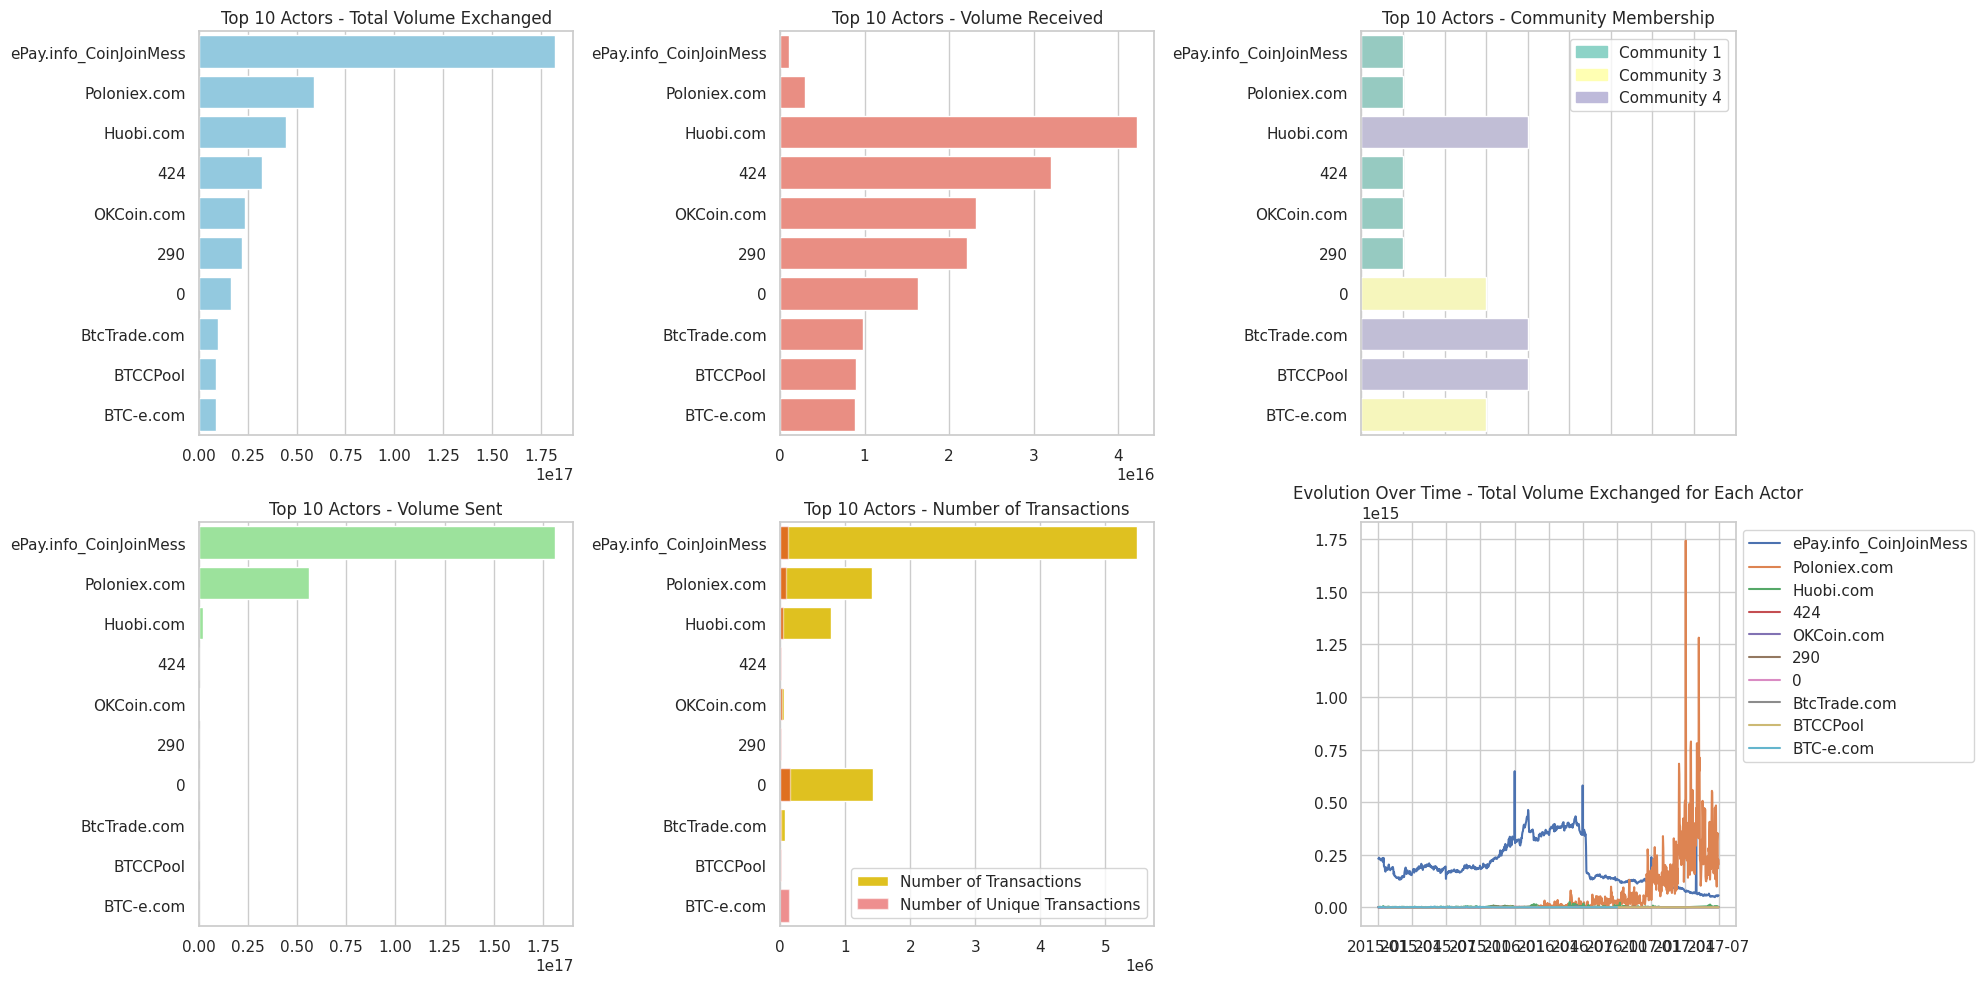

In [19]:
overview_of_top_actors(actors, top=10)

# Analysis of the Community Structure

We will try to analyze the community structure of the network. Our goal is to have an in-depth understanding of the community structure of the network. We want to understand if the community structure is stable over time, or if it changes over time. We also want to understand if a community is homogeneous or not.

In [89]:
def comparison_actors_community_transactions(communities, top_communities=10, top_actors=5):
    fig, axes = plt.subplots(top_communities, 1, figsize=(20, 30), squeeze=False)
    sns.set(style="whitegrid")
    
    sorted_communities = sorted(communities, key=lambda x: x.get_volume(), reverse=True)
    top_communities_list = sorted_communities[:top_communities]
    
    for i, community in enumerate(top_communities_list):
        actors_names = community.get_members()
        actors_list = [actor_dict[name] for name in actors_names]
        top_actors_list = sorted(actors_list, key=lambda x: x.get_total_volume(), reverse=True)[:top_actors]
        actors_names = list(map(lambda actor: actor.get_name(), top_actors_list))
        
        # plot community transactions
        volume_by_day = community.get_transactions_volume_by_day()
        max_value = max([t.value for t in volume_by_day])
        normalized_values = [t.value / max_value for t in volume_by_day]
        moving_average = np.convolve(normalized_values, np.ones(7), 'valid') / 7
        sns.lineplot(x=[t.date for t in volume_by_day[:len(moving_average)]], y=moving_average, label=community.get_name(), ax=np.atleast_1d(axes[i, 0])[0])
        
        # plot the transactions of the top actors
        for actor in top_actors_list:
            volume_by_day_actor = actor.get_transactions_volume_by_day()
            
            if volume_by_day_actor:  # Check if the list is not empty
                max_value_actor = max([t.value for t in volume_by_day_actor])
                normalized_values_actor = [t.value / max_value_actor for t in volume_by_day_actor]
                moving_average_actor = np.convolve(normalized_values_actor, np.ones(7), 'valid') / 7
                sns.lineplot(x=[t.date for t in volume_by_day_actor[:len(moving_average_actor)]], y=moving_average_actor, label=actor.get_name(), ax=np.atleast_1d(axes[i, 0])[0])
            
        axes[i, 0].set_title(f'Evolution Over Time - Total Volume Exchanged for Each Actor in Community {community.get_name()}')
        axes[i, 0].legend(loc='upper left', bbox_to_anchor=(1, 1))
        
    plt.tight_layout()
    plt.show()


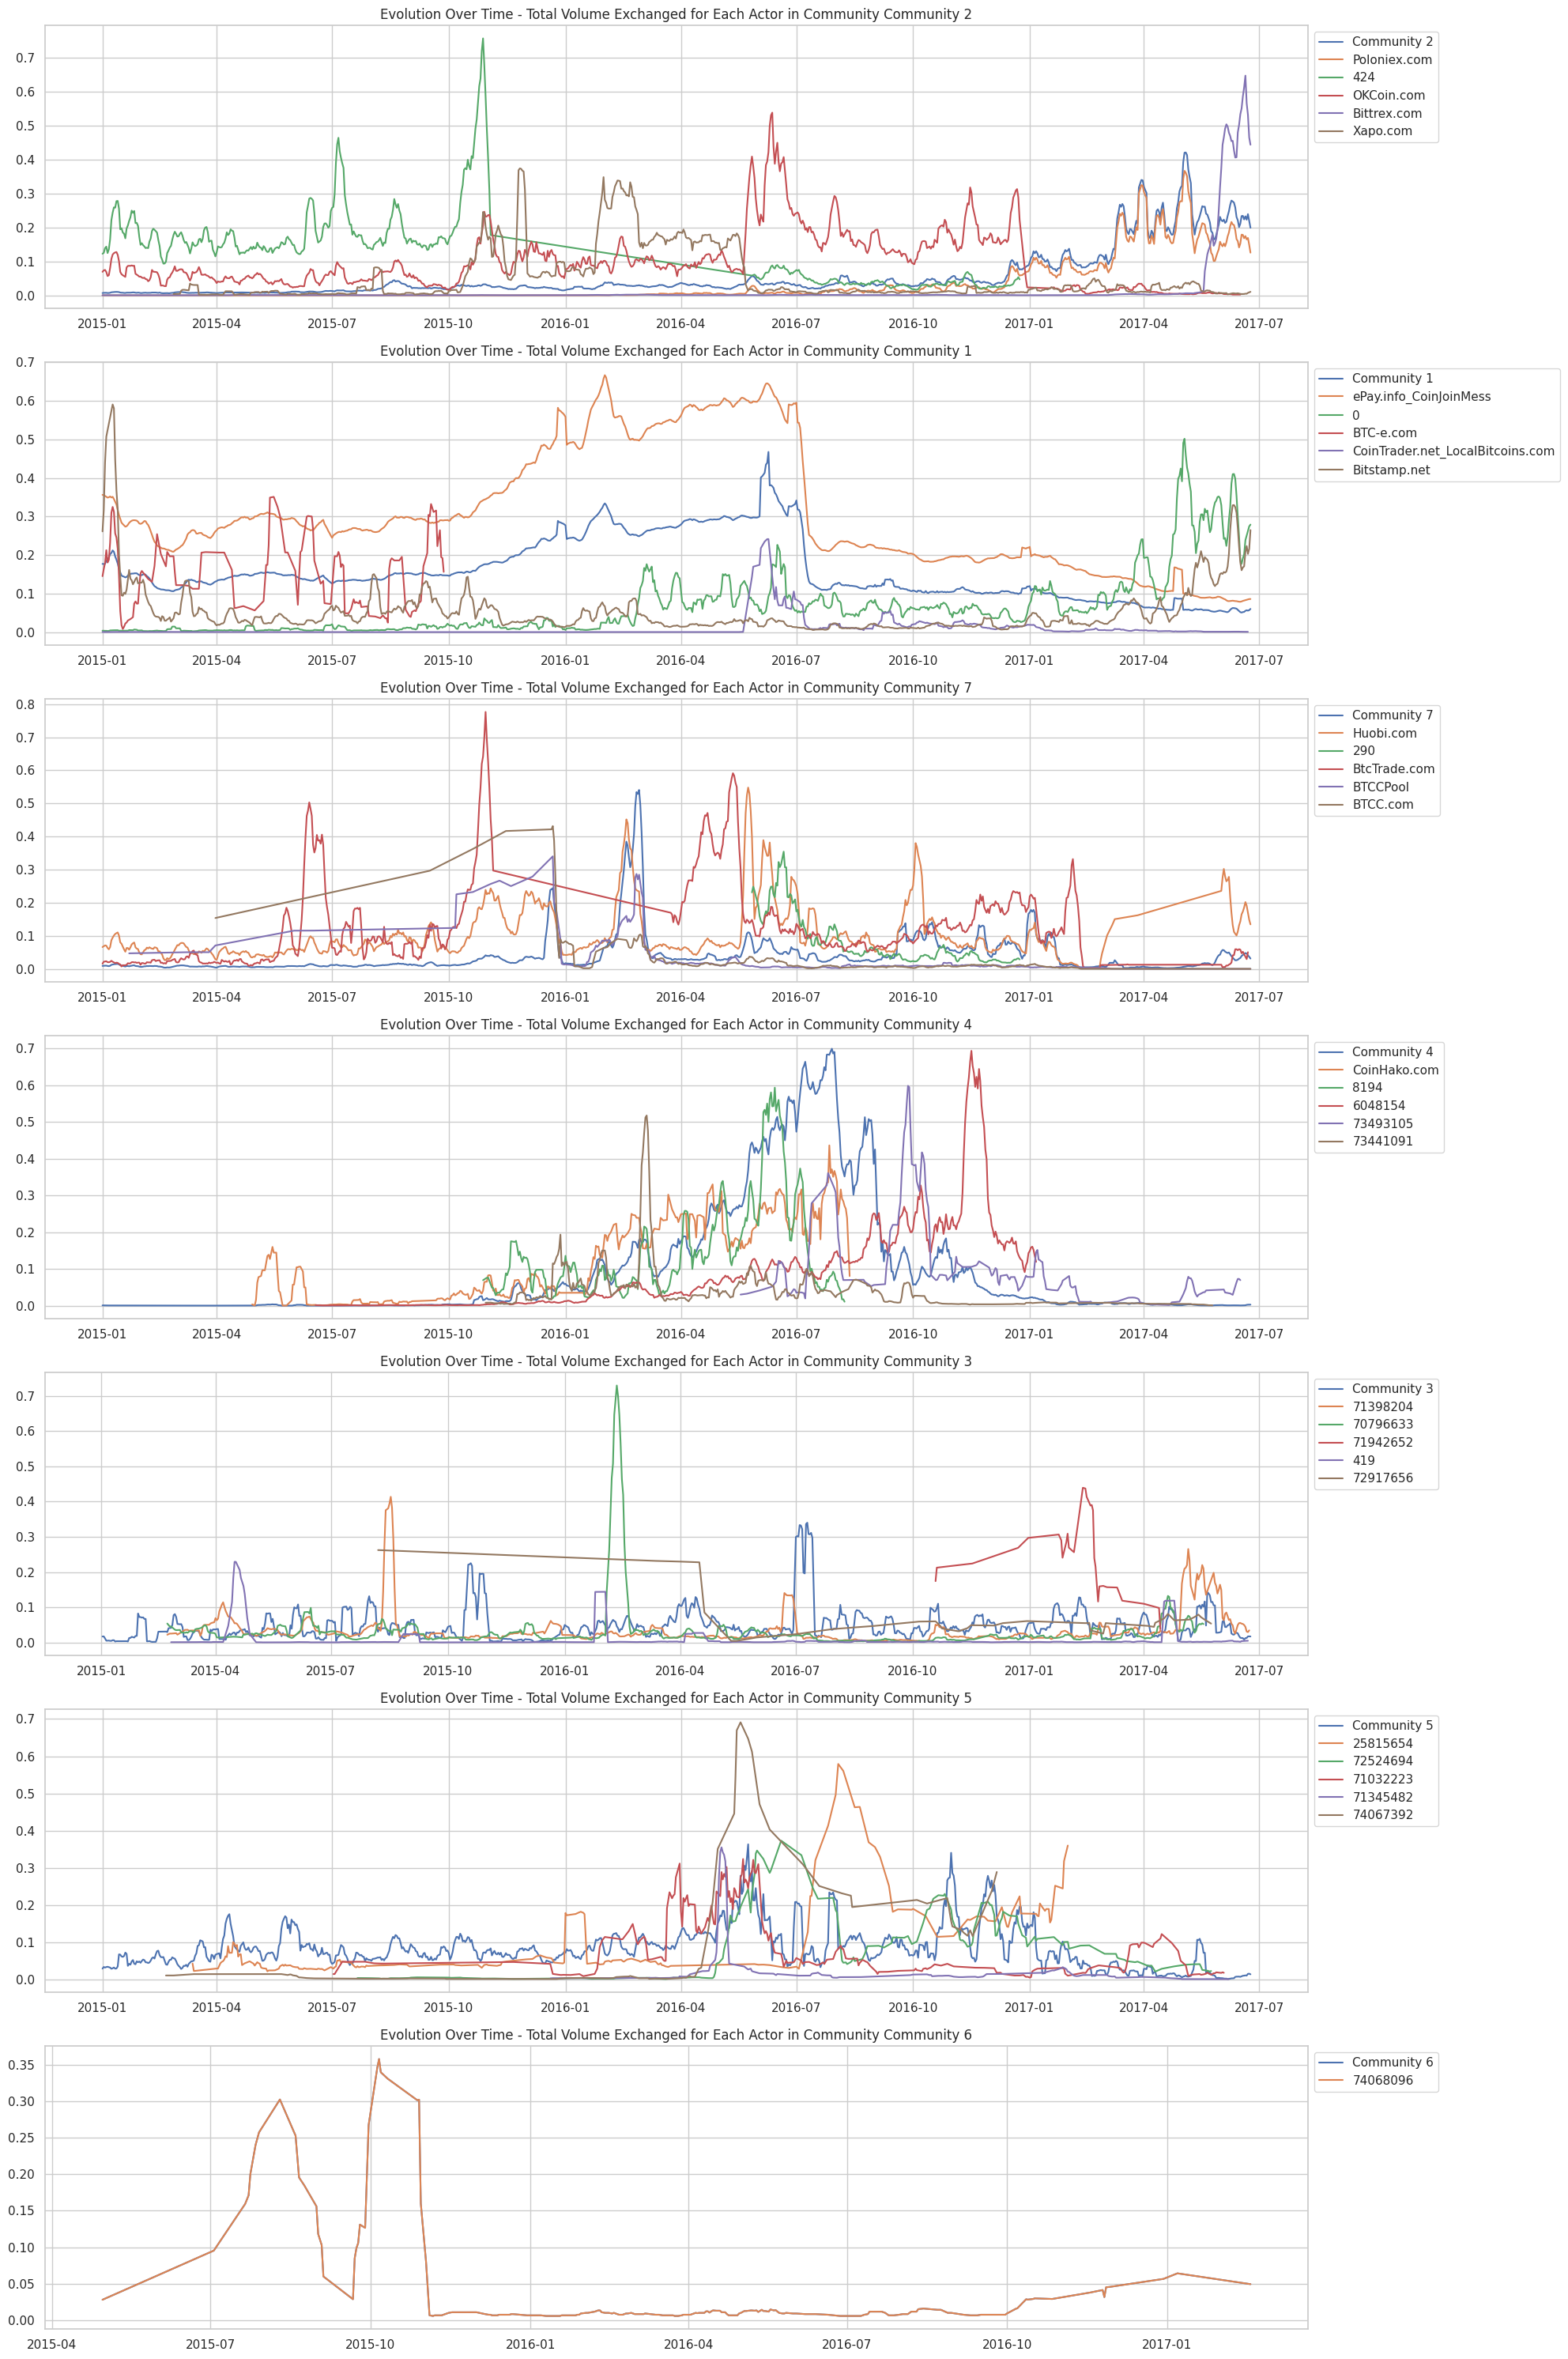

In [90]:
comparison_actors_community_transactions(communities, top_communities=len(communities), top_actors=5)

Based on the previous plot we can tell that the most influential actors are the ones that are involved in the most transactions. We will use this information to compute the most influential actors in each community. We will compute the most influential actors in each community by computing the correlation between the actors transactions and the community transactions. The actors with the highest correlation will be the most influential actors in the community. 

We will set a threshold to determine if an actor is influential or not. We will consider that an actor is influential if the correlation between the actor's transactions and the community transactions is higher than the threshold. We will set the threshold to 0.5.

In [132]:
def correlation_between_community_top_actors(communities, top_communities=10, top_actors=5):
    sorted_communities = sorted(communities, key=lambda x: x.get_volume(), reverse=True)
    top_communities_list = sorted_communities[:top_communities]
    
    correlation_coefficients = {}
    
    for community in top_communities_list:
    
        community_volume_by_day = community.get_transactions_volume_by_day()
        community_volume = np.array([t.value for t in community_volume_by_day])
        
        actors_names = community.get_members()
        actors_list = [actor_dict[name] for name in actors_names]
        top_actors_list = sorted(actors_list, key=lambda x: x.get_total_volume(), reverse=True)[:top_actors]

        # Initialize a dictionary to store correlation coefficients for each member
        correlation_matrix = np.zeros((len(top_actors_list) + 1, len(community_volume_by_day)))
        
        correlation_coefficients[community.get_name()] = {}

        # Loop through each member
        for i, member in enumerate([community] + top_actors_list):
            member_volume_by_day = member.get_transactions_volume_by_day()
            member_volume = np.array([t.value for t in member_volume_by_day])

            # Ensure both arrays have the same size
            min_size = min(len(community_volume), len(member_volume))
            if min_size > 0:
                community_volume_sub = community_volume[:min_size]
                member_volume_sub = member_volume[:min_size]

                # Calculate correlation coefficient
                correlation = np.corrcoef(community_volume_sub, member_volume_sub)[0, 1]
                correlation_coefficients[community.get_name()][member.get_name()] = correlation
                correlation_matrix[i, :min_size] = [correlation] * min_size
            
    return correlation_coefficients

def filter_relevant_correlations(correlation_coefficients, threshold=0.6):
    relevant_correlations = {}
    
    for community in correlation_coefficients:
        relevant_correlations[community] = {}
        
        for member in correlation_coefficients[community]:
            if abs(correlation_coefficients[community][member]) > threshold and member != community:
                relevant_correlations[community][member] = correlation_coefficients[community][member]
                
        if len(relevant_correlations[community]) == 0:
            del relevant_correlations[community]
                
    return relevant_correlations

In [121]:
def display_correlation_coefficients(correlation_coefficients):
    table = []
    for member_name, correlation in correlation_coefficients.items():
        table.append([member_name, correlation])

    # Display the table
    print(tabulate(table, headers=["Member", "Correlation Coefficient"]))

In [133]:
corr_coeff = correlation_between_community_top_actors(communities)

relevant_correlation_coefficients = filter_relevant_correlations(corr_coeff)
display_correlation_coefficients(relevant_correlation_coefficients)

Member       Correlation Coefficient
-----------  -----------------------------------------------------------------------
Community 2  {'Poloniex.com': 0.9871274368848387, 'Bittrex.com': 0.7120068379781799}
Community 1  {'ePay.info_CoinJoinMess': 0.948382082395606}
Community 4  {'6048154': 0.6247268991358335}
Community 6  {'74068096': 0.9999999999999999}


# Bitcoin Price Data Integration

We will integrate the bitcoin price data to our analysis. We will use the bitcoin price data to analyze the correlation between the bitcoin price and the volume of transactions in the network. We will also analyze the correlation between the bitcoin price and the volume of transactions in the communities.

In [124]:
# Import the Bitcoin price data
bitcoin_price_data = pd.read_csv("../data/timeseries/2015/external.csv")
bitcoin_price_data['date'] = pd.to_datetime(bitcoin_price_data[['year', 'month', 'day']])

# drop the columns we don't need
bitcoin_price_data = bitcoin_price_data.drop(columns=['year', 'month', 'day', 'weekday', 'week'])
bitcoin_price_data

,PriceUSD,HashRate,date
0,315.942732,333345.017260,2015-01-02
1,285.647310,327284.198765,2015-01-03
2,263.334575,347486.927083,2015-01-04
3,275.003852,315162.561773,2015-01-05
4,287.549521,319203.107437,2015-01-06
...,...,...,...
359,422.705895,952298.517472,2015-12-27
360,421.052880,701449.151894,2015-12-28
361,431.340021,738612.020869,2015-12-29
362,426.043647,766484.172600,2015-12-30


In [135]:
def plot_community_vs_btc_price(community, bitcoin_price_data):
    plt.figure(figsize=(20, 10))
    
    scaler = MinMaxScaler()
    volume_by_day = community.get_transactions_volume_by_day()[:len(bitcoin_price_data['date'])]
    scaled_volume_by_day = scaler.fit_transform(np.array([t.value for t in volume_by_day]).reshape(-1, 1))
    scaled_volume_by_day = scaled_volume_by_day.flatten()
    
    scaled_btc_price = scaler.fit_transform(np.array(bitcoin_price_data['PriceUSD']).reshape(-1, 1))
    scaled_btc_price = scaled_btc_price.flatten()
    
    scaled_community_volume = scaler.fit_transform(np.array([t.value for t in volume_by_day]).reshape(-1, 1))
    scaled_community_volume = scaled_community_volume.flatten()
    
    scaled_community_volume = scaled_community_volume[:len(scaled_btc_price)]

    sns.lineplot(x=bitcoin_price_data['date'], y=scaled_btc_price, label="Bitcoin Price")
    sns.lineplot(x=bitcoin_price_data['date'], y=scaled_community_volume, label="Community Volume")
    
    # Convert to Pandas Series to use rolling mean
    btc_series = pd.Series(scaled_btc_price)
    community_series = pd.Series(scaled_community_volume)
    
    # Compute moving average
    btc_scaled_moving_avg = btc_series.rolling(window=50).mean()
    community_scaled_moving_avg = community_series.rolling(window=50).mean()
    
    # Plot moving average
    sns.lineplot(x=bitcoin_price_data['date'], y=btc_scaled_moving_avg, label="50-day SMA Bitcoin Price")
    sns.lineplot(x=bitcoin_price_data['date'], y=community_scaled_moving_avg, label="50-day SMA Community Volume")
    
    # Set labels and title
    plt.title("Evolution of Bitcoin Price with 50-day SMA and First Community")
    plt.xlabel("Date")
    plt.ylabel("Bitcoin Price (USD) / Community Volume / Stock Market Index (Scaled)")

    # Show legend
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

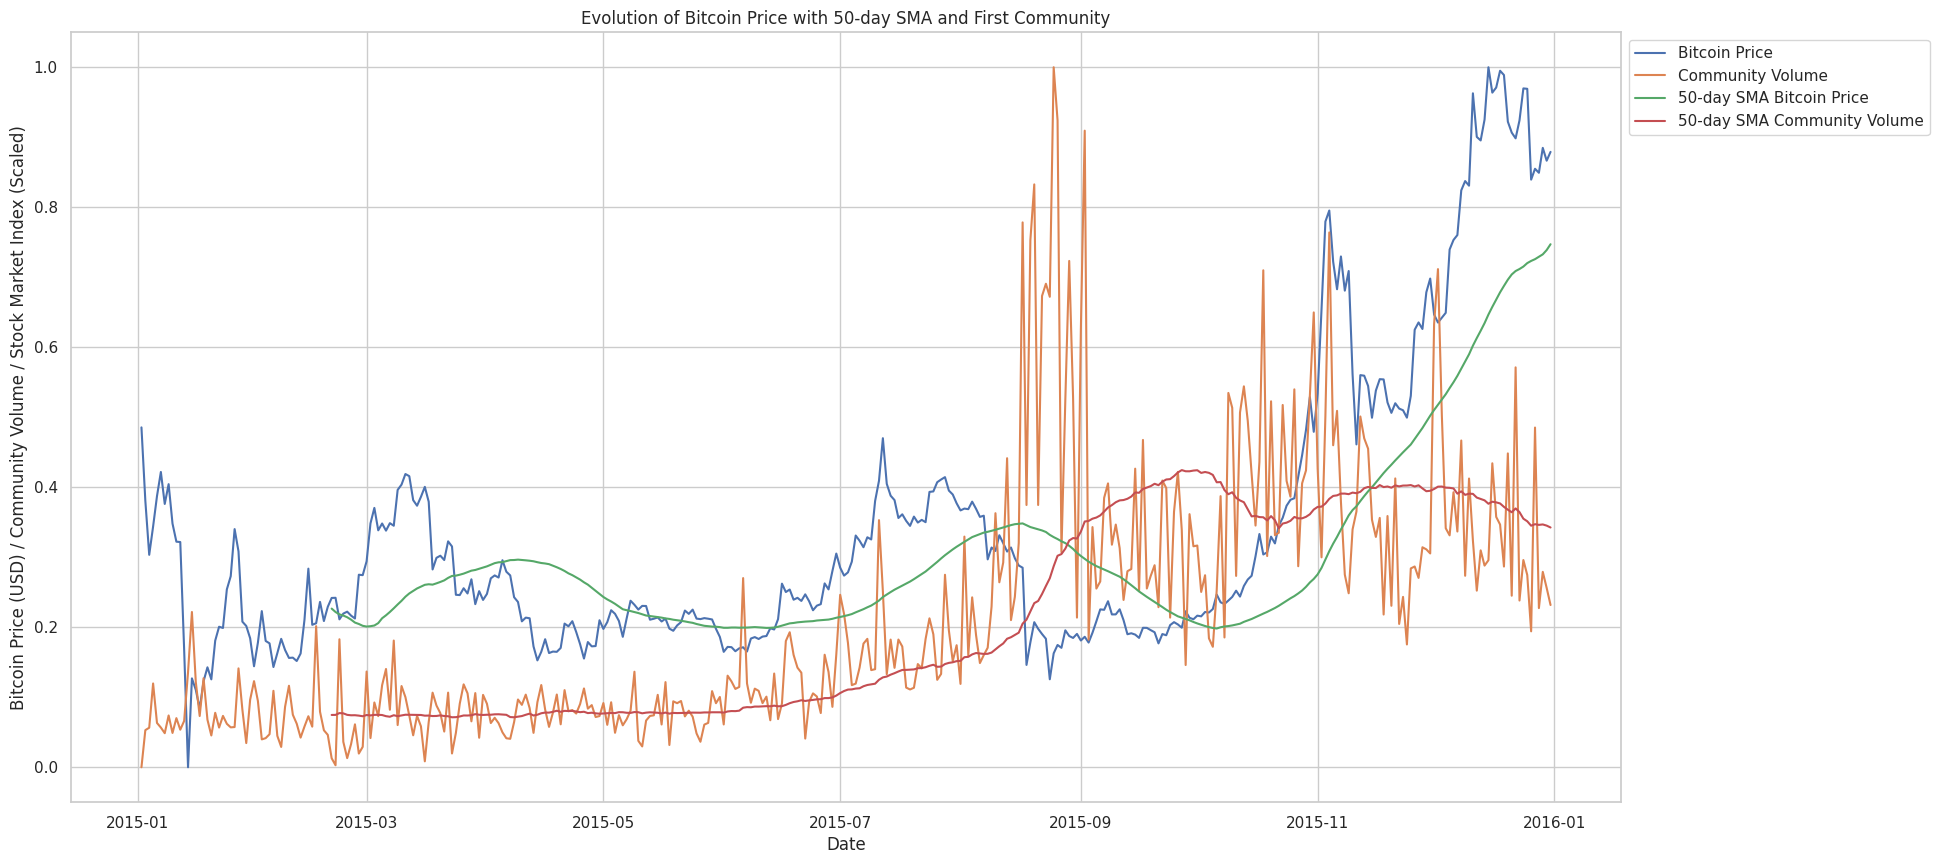

In [136]:
top_1 = sorted(communities, key=lambda x: x.get_volume(), reverse=True)[0]
plot_community_vs_btc_price(top_1, bitcoin_price_data)